# Imports and Text from Data Source

In [26]:
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
import wget
from os.path import exists


SONNETS_FILE = './sonnets.txt'
if not exists(SONNETS_FILE):
    # sonnets.txt
    wget.download("https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K")

    # Read the data
    with open('./sonnets.txt') as f:
        data = f.read()

# Create Token Sequences from Text

In [44]:
# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

# create Tokenizer and sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
tokenizer.texts_to_sequences([corpus[0]])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


[[34, 417, 877, 166, 213, 517]]

### Generating n_grams
Return a list containing the n_gram sequences for each line in the corpus

In [46]:
input_sequences = []
# Loop over every line
for line in corpus:
    # Tokenize the current line
    token_list = tokenizer.texts_to_sequences([line])[0]
    # Loop over the line several times to generate the subphrases
    for i in range(1, len(token_list)):
        # Generate the subphrase
        n_gram_sequence = token_list[:i+1]
        # Append the subphrase to the sequences list
        input_sequences.append(n_gram_sequence)
# Save max length
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


### Add Padding

In [47]:
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))


print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


### Split the data into features and (1-hot) labels

In [48]:
features =  input_sequences[:,:-1]
labels = input_sequences[:,-1]
labels = to_categorical(labels, num_classes=total_words) #1-hot conversion

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


### Build the Model
- use a softmax activated Dense layer instead. 
- output layer will have one neuron for each word in the vocabulary. 
    - given an input token list, the output array of the final layer will have the probabilities for each word.

- achieve an accuracy of at least 80%.
- problem can be solved with 2 layers excluding dense

In [49]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(300)))
model.add(Dense(total_words, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

### Train the model

In [50]:
# Train the model
history = model.fit(features, labels, epochs=50, verbose=1)

Epoch 1/50
318/484 [==================>...........] - ETA: 8s - loss: 6.9171 - accuracy: 0.0230

KeyboardInterrupt: 

# Training curves of model

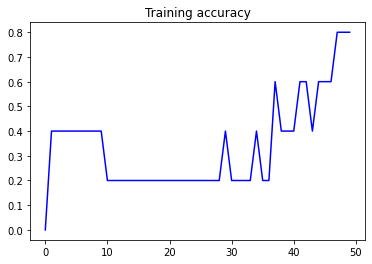

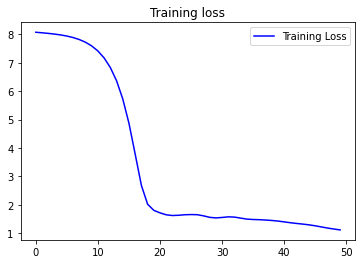

In [51]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

# Download Model History

In [ ]:
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()

# Test Model

In [ ]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	# Convert the text into sequences
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	# Pad the sequences
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	# Get the probabilities of predicting a word
	predicted = model.predict(token_list, verbose=0)
	# Choose the next word based on the maximum probability
	predicted = np.argmax(predicted, axis=-1).item()
	# Get the actual word from the word index
	output_word = tokenizer.index_word[predicted]
	# Append to the current text
	seed_text += " " + output_word

print(seed_text)